In [34]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
import os
os.chdir('../../')

In [36]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *

# Predictions

### Load Pretrained

In [37]:
# Config
config = default_config()

# Location of your midi files
midi_path =  Path('data/midi/examples')

# Location of saved datset
data_path = Path('data/numpy')
data_save_name = 'musicitem_data_save.pkl'

In [38]:
# Data
data = load_data(data_path, data_save_name)
vocab = data.vocab

FileNotFoundError: [Errno 2] No such file or directory: 'data/numpy/musicitem_data_save.pkl'

In [ ]:
# Pretrained Model
# Download pretrained model if you haven't already
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained'
pretrained_path = untar_data(pretrained_url, dest=data_path)
load_path = pretrained_path/'MusicTransformer.pth'; load_path

In [39]:
# Learner
learn = music_model_learner(data, config=config.copy(), pretrained_path=load_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data/numpy/pretrained/MusicTransformer.pth'

## Load Exising Song

#### Choose existing midi file as a starting point

In [8]:
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:4]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid'),
 PosixPath('data/midi/examples/Can You Feel The Love Tonight - Elton John - Verse.mid'),
 PosixPath('data/midi/examples/Locked Out Of Heaven - Bruno Mars - Chorus.mid')]

In [9]:
idx = 0
f = midi_files[idx]; f

PosixPath('data/midi/examples/Levels - Avicii - Verse.mid')

#### Trim Song

Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [10]:
cutoff_beat = 5

item = MusicItem.from_file(f, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

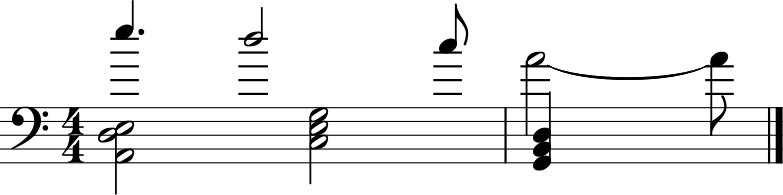

In [11]:
seed_item.show()

In [12]:
seed_item.play()

## Sampling

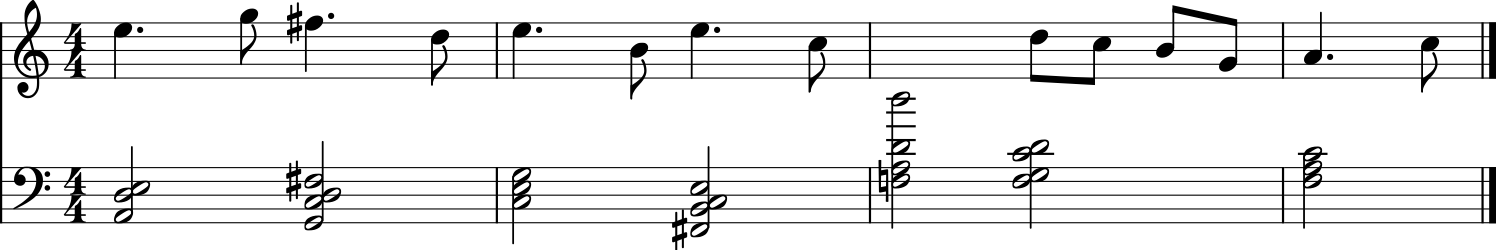

In [14]:
temp = (1.2,0.9) 
top_k = 12
top_p = 0.9

pred, full = learn.predict(item.trim_to_beat(1), n_words=100, min_bars=12, temperatures=temp, top_k=top_k, top_p=top_p)
full.split_parts().show()

### Too Conservative

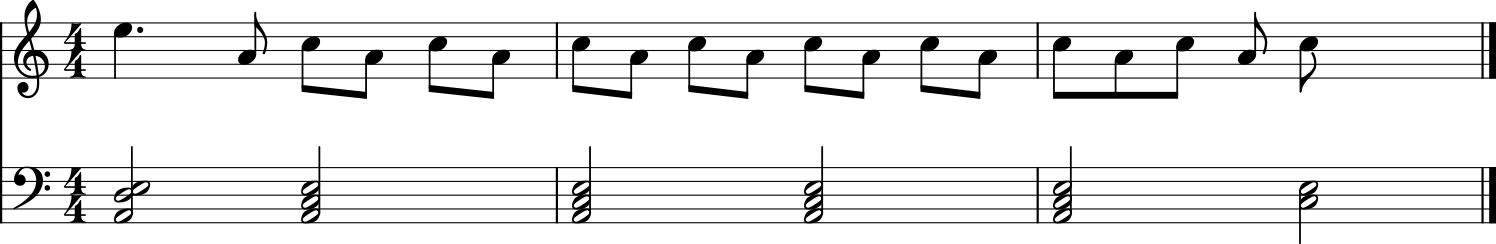

In [16]:
temp = (0.1, 0.1)
top_k = 3
top_p = 0.3

pred, full = learn.predict(item.trim_to_beat(1), n_words=100, min_bars=12, temperatures=temp, top_k=top_k, top_p=top_p)
full.split_parts().show()

### Too Erratic

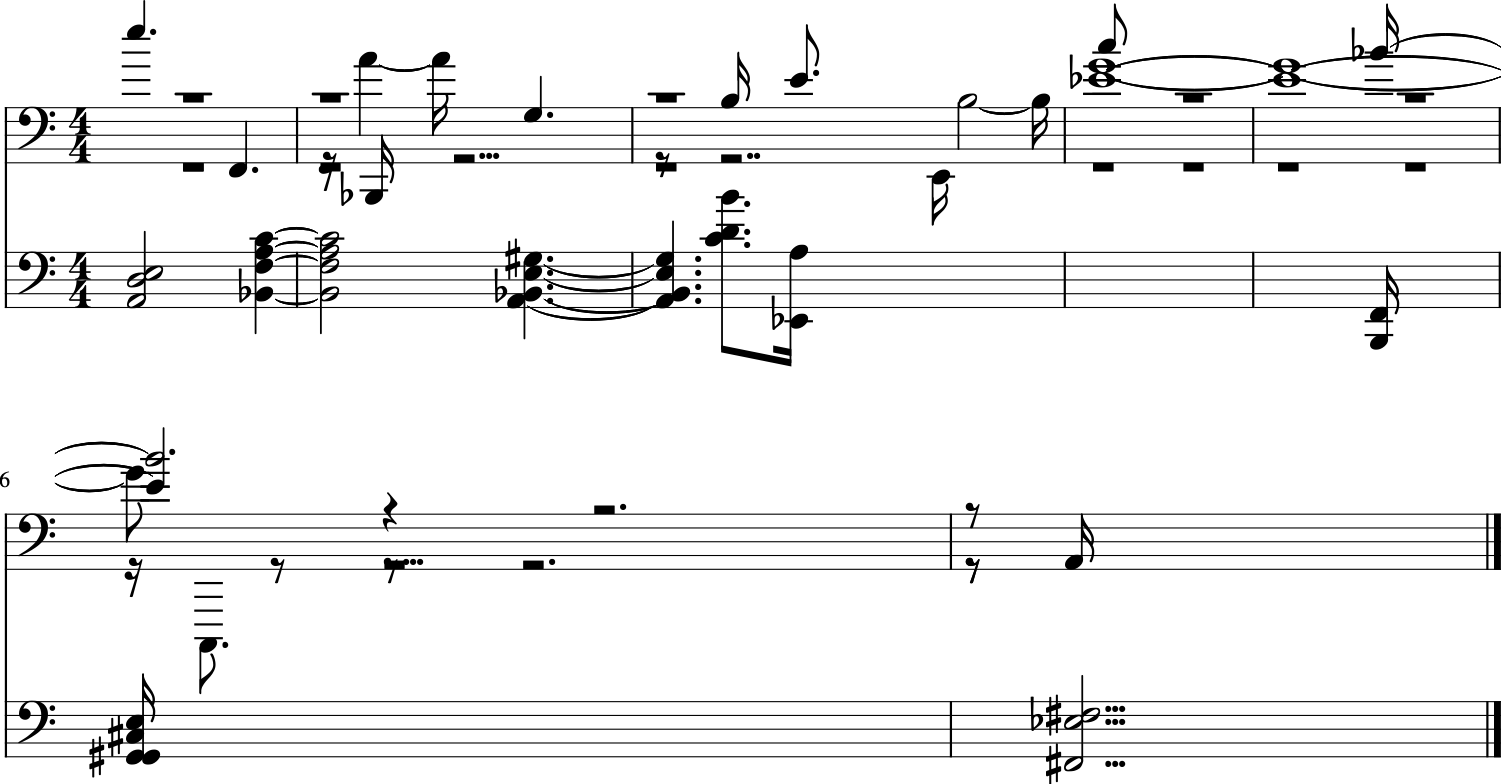

In [17]:
temp = (1.8,1.5)
top_k = 90
top_p = 0.99

pred, full = learn.predict(item.trim_to_beat(1), n_words=100, min_bars=12, temperatures=temp, top_k=top_k, top_p=top_p)
full.split_parts().show()

### Just Right

## Sampling Controls - Temperature / Top-K / Top-P

In [18]:
import torch
import torch.nn.functional as F
torch.set_printoptions(precision=10)

a = torch.arange(4).float()

## Temperature - Injecting Randomness

**T = 1**

In [21]:
t_1 = F.softmax(a, dim=-1); t_1

tensor([0.0320586041, 0.0871443227, 0.2368828356, 0.6439142823])

**T = 0.5**

In [22]:
t_05 = F.softmax(a / 0.5, dim=-1); t_05

tensor([0.0021440089, 0.0158422012, 0.1170589030, 0.8649548292])

In [22]:
torch.multinomial(t_05, 8, replacement=True)

tensor([3, 3, 3, 3, 3, 3, 3, 3])

**Temp = 2**

In [23]:
t_2 = F.softmax(a / 2, dim=-1); t_2

tensor([0.1015363261, 0.1674050987, 0.2760043442, 0.4550542235])

In [24]:
torch.multinomial(t_2, 8, replacement=True)

tensor([3, 3, 0, 2, 0, 2, 2, 2])

## Top K - Filtering Outliers

In [25]:
F.softmax(top_k_top_p(a, top_k=2), dim=-1)

tensor([0.0000000000, 0.0000000000, 0.2689414322, 0.7310585976])

In [26]:
a10 = torch.arange(10).float()
F.softmax(top_k_top_p(a10, top_k=2), dim=-1)

tensor([0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
        0.0000000000, 0.0000000000, 0.0000000000, 0.2689414322, 0.7310585976])

## Top P (Nucleus Sampling)

Dynamic filtering

In [27]:
# Cumulative probabilities over P are filtered out
torch.cumsum(F.softmax(a.sort(descending=True)[0], dim=-1), dim=-1)

tensor([0.6439142823, 0.8807971478, 0.9679414630, 1.0000000000])

In [31]:
F.softmax(top_k_top_p(a, top_p=0.65), dim=-1)

tensor([0.0000000000, 0.0000000000, 0.2689414322, 0.7310585976])

In [32]:
F.softmax(top_k_top_p(a, top_p=0.89), dim=-1)

tensor([0.0000000000, 0.0900305733, 0.2447284758, 0.6652409434])

In [33]:
F.softmax(top_k_top_p(a/2, top_p=0.89), dim=-1)

tensor([0.0000000000, 0.1863237321, 0.3071959019, 0.5064803958])

### Pop Music Theory

According to hooktheory, the most popular chord progression is I-V-vi-IV  
https://www.hooktheory.com/theorytab/common-chord-progressions

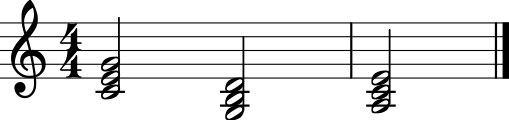

In [36]:
# Let's create a partial progression I-V-vi
p = music21.stream.Part()
p.append(music21.chord.Chord('C4 E4 G4', type='half')) # I
p.append(music21.chord.Chord('G3 B3 D4', type='half')) # V
p.append(music21.chord.Chord('A3 C4 E4', type='half')) # vi
s = music21.stream.Score([p])
chord_item = MusicItem.from_stream(s, vocab)
chord_item.show()

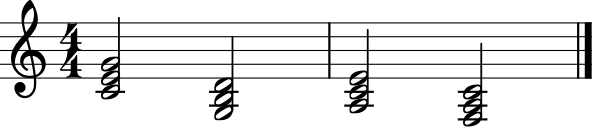

In [37]:
temperaturs = (0.5,0.5) # Let's lower the note randomness for this test
pred, full = learn.predict(chord_item, n_words=10, temperatures=(0.5,0.5))
full.show()

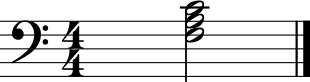

In [38]:
# Predicted chords - IV
pred.show()

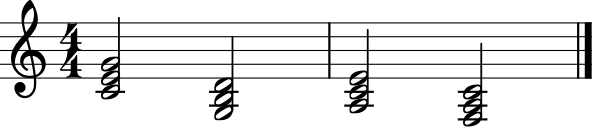

In [39]:
# Full sequence
chord_item.append(pred).show()

Looks like it predicted the most popular progression!

#### Predict without a starting sequence

In [ ]:
empty_item = MusicItem.empty(vocab)

In [ ]:
pred = learn.predict(empty_item, n_words=200)

In [ ]:
pred.show()